In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score,RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True



`PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

`HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
    
`CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

`Cabin`- The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    
`Destination` - The planet the passenger will be debarking to.
    
`Age` - The age of the passenger.
    
`VIP` - Whether the passenger has paid for special VIP service during the voyage.
    
`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    
`Name` - The first and last names of the passenger.
    
`Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [3]:
combine = [train,test]
for df in combine:
    print(df.isna().sum())
    print()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64



# Features with nan

In [4]:
# features with na
na_features_train = [features for features in train.columns if (train[features].isna().sum()>0)]
na_features_test = [features for features in test.columns if (test[features].isna().sum()>0)]

print(na_features_train)
print(na_features_test)
print()


#count of features with na
na_features_train_count = {features:train[features].isna().sum() for features in na_features_train}
na_features_test_count = {features:test[features].isna().sum() for features in na_features_test}

print(na_features_train_count)
print(na_features_test_count)

['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']
['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']

{'HomePlanet': 201, 'CryoSleep': 217, 'Cabin': 199, 'Destination': 182, 'Age': 179, 'VIP': 203, 'RoomService': 181, 'FoodCourt': 183, 'ShoppingMall': 208, 'Spa': 183, 'VRDeck': 188, 'Name': 200}
{'HomePlanet': 87, 'CryoSleep': 93, 'Cabin': 100, 'Destination': 92, 'Age': 91, 'VIP': 93, 'RoomService': 82, 'FoodCourt': 106, 'ShoppingMall': 98, 'Spa': 101, 'VRDeck': 80, 'Name': 94}


True     4378
False    4315
Name: Transported, dtype: int64

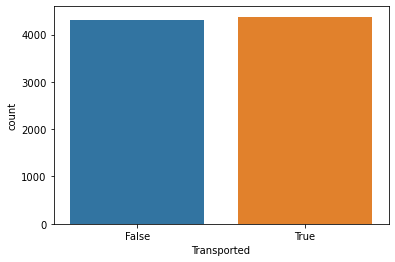

In [5]:
sns.countplot(x = 'Transported',data = train)
train['Transported'].value_counts()

The data is balanced.

# Numerical features

In [6]:
df = train.copy()
df1 = test.copy()

numerical_features_train = df.select_dtypes(exclude='O').columns
numerical_features_test = df1.select_dtypes(exclude='O').columns

print(numerical_features_train)
print(numerical_features_test)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported'],
      dtype='object')
Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')


## Discrete numerical features

In [7]:
df = train.copy()
df1 = test.copy()

discrete_numerical_features_train = [features for features in numerical_features_train if len(df[features].unique())<20]
discrete_numerical_features_test = [features for features in numerical_features_test if len(df1[features].unique())<20]

print(discrete_numerical_features_train)
print(discrete_numerical_features_test)

['Transported']
[]


We have no discrete features in our dataset. The transported feature is target feature

## Continuous numerical features

In [8]:
continuous_numerical_features_train= [features for features in numerical_features_train if features not in discrete_numerical_features_train]
continuous_numerical_features_test = [features for features in numerical_features_test  if features not in discrete_numerical_features_test]

print(continuous_numerical_features_train)
print(continuous_numerical_features_test)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


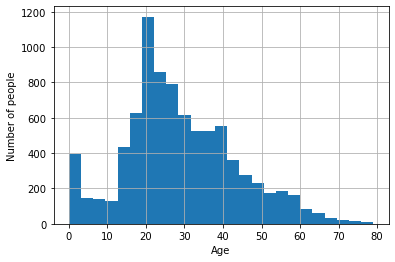

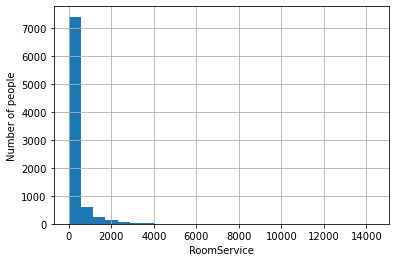

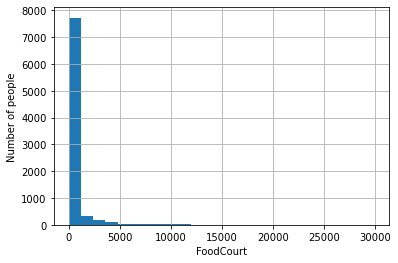

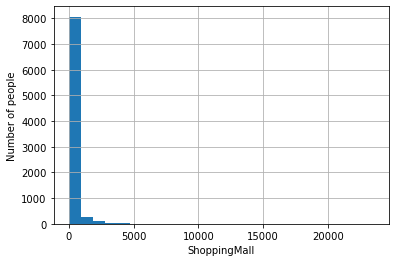

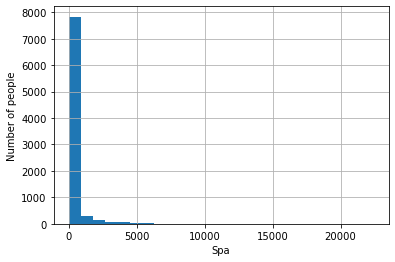

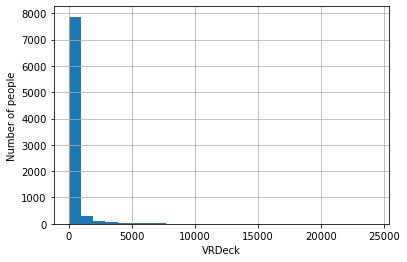

In [9]:
df = train.copy()
df1 = test.copy()

for features in continuous_numerical_features_train:
    df[features].hist(bins = 25)
    plt.xlabel(features)
    plt.ylabel('Number of people')
    plt.show()
    

In [10]:
# df[df['Age'] == np.nan]

## Observation - 
1. Most of the people are from 18-22 `Age` i.e adults.

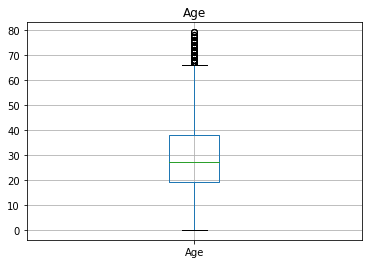

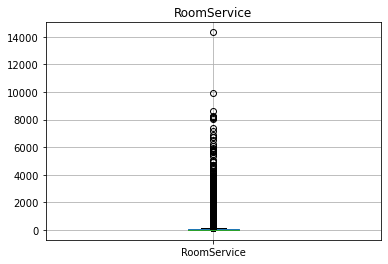

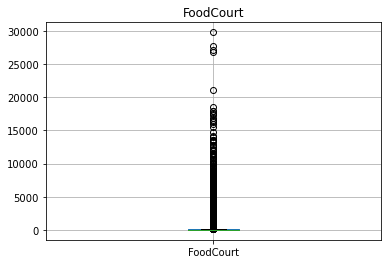

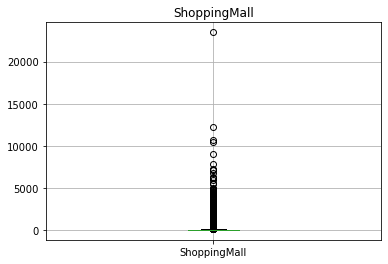

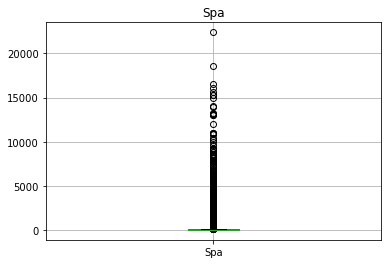

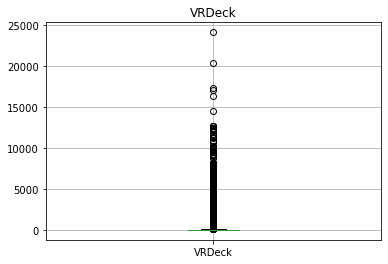

In [11]:
df = train.copy()
# Checking outlier
for features in continuous_numerical_features_train:
    df.boxplot(column=features)
    plt.title(features)
    plt.show()

We have outliers in continuous features which will be removed later

# Categorical features

In [12]:
df = train.copy()
df1 = test.copy()

categorical_features_train = df.select_dtypes(include='O').columns
categorical_features_test = df1.select_dtypes(include='O').columns

print(categorical_features_train)
print(categorical_features_test)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name'],
      dtype='object')
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name'],
      dtype='object')


In [13]:
categories_count_train = {features:len(df[features].unique()) for features in categorical_features_train}
categories_count_train = dict(sorted(categories_count_train.items(), key = lambda ele: ele[1]))
print(categories_count_train)


categories_count_test = {features:len(df1[features].unique()) for features in categorical_features_test}
categories_count_test = dict(sorted(categories_count_test.items(), key = lambda ele: ele[1]))
print(categories_count_test)

{'CryoSleep': 3, 'VIP': 3, 'HomePlanet': 4, 'Destination': 4, 'Cabin': 6561, 'Name': 8474, 'PassengerId': 8693}
{'CryoSleep': 3, 'VIP': 3, 'HomePlanet': 4, 'Destination': 4, 'Cabin': 3266, 'Name': 4177, 'PassengerId': 4277}


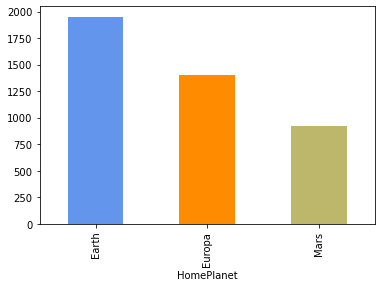

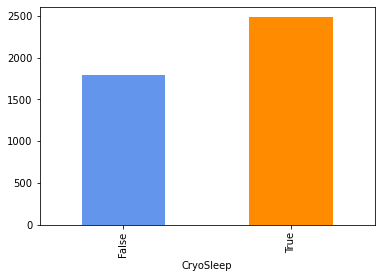

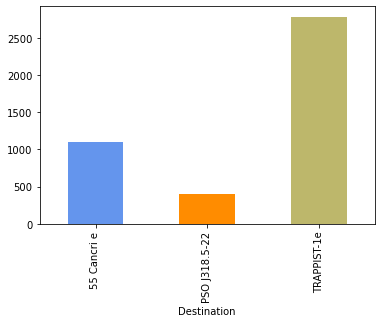

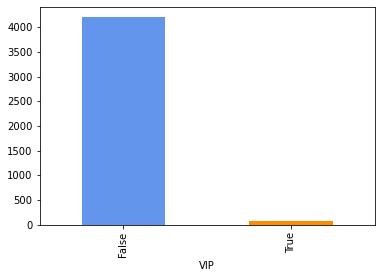

In [14]:
for features in categorical_features_train:
    if features not in 'Cabin'+'Name'+'PassengerId':
        df.groupby(features)['Transported'].sum().plot(kind='bar',color=['cornflowerblue','darkorange','darkkhaki'])
        plt.show()

### Observation - 

1. Most of the passenger are from `Earth`.
2. Most of the passenger were in `cyrosleep`.
3. Most of the passenger's destination is `Trappist-1e`.
4. Most of the people were not opt for `VIP` service.

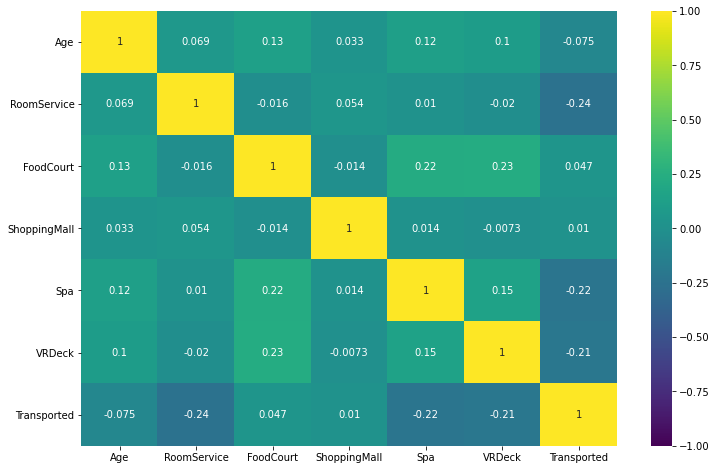

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(),annot=True,vmin=-1,vmax=1,cmap='viridis')
plt.show()

### Observation
We can assume our features to be independent

# Feature Engineering

Converting Output feature to int

In [16]:
train['Transported'] = train['Transported'].astype(int)
train['Transported']

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 8693, dtype: int32

### Making Passenger Id as Index

In [17]:
train = train.set_index('PassengerId')
test = test.set_index('PassengerId')

### Combining Train and test

In [18]:
df = pd.concat([train,test],axis=0)
df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN


In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,12700.0,28.771969,14.387261,0.0,19.0,27.0,38.0,79.0
RoomService,12707.0,222.897852,647.596664,0.0,0.0,0.0,49.0,14327.0
FoodCourt,12681.0,451.961675,1584.370747,0.0,0.0,0.0,77.0,29813.0
ShoppingMall,12664.0,174.906033,590.558690,0.0,0.0,0.0,29.0,23492.0
Spa,12686.0,308.476904,1130.279641,0.0,0.0,0.0,57.0,22408.0
VRDeck,12702.0,306.789482,1180.097223,0.0,0.0,0.0,42.0,24133.0
Transported,8693.0,0.503624,0.500016,0.0,0.0,1.0,1.0,1.0


### Detecting and Removing Outliers

In [20]:
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound=Q1 - 1.5 * IQR
    upper_bound=Q3 + 1.5 * IQR
    trueList = ~((df < lower_bound) |(df > upper_bound))
    return trueList

In [21]:
nonOutlierList = Remove_Outlier_Indices(df)
# Non-Outlier Subset of the Given Dataset
dfSubset = df[nonOutlierList]
dfSubset

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,NaN,44.0,Juanna Vines,1.0
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,NaN,0.0,NaN,49.0,Altark Susent,0.0
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,NaN,NaN,NaN,NaN,Solam Susent,0.0
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,NaN,70.0,NaN,NaN,2.0,Willy Santantines,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,NaN,17.0,10.0,NaN,Matty Scheron,NaN
9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN


## Handling missing values 

In [22]:
df.isnull().sum()

HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

In [23]:
dfSubset['HomePlanet']  = dfSubset['HomePlanet'].fillna(dfSubset['HomePlanet'].mode().item())
dfSubset['CryoSleep']   = dfSubset['CryoSleep'].fillna(dfSubset['CryoSleep'].mode().item())
dfSubset['Cabin']       = dfSubset['Cabin'].fillna('X/1900/X') # becauSe max iS 1894
dfSubset['Destination'] = dfSubset['Destination'].fillna(dfSubset['Destination'].mode().item())
dfSubset['VIP']         = dfSubset['VIP'].fillna(dfSubset['VIP'].mode().item())
dfSubset['Age']         = dfSubset['Age'].fillna(dfSubset['Age'].mean())

### Making Age group

In [24]:
def age_group(feature):
    group = ''
    if feature<5.0:
        group = 'Baby'
    elif feature>=5.0 and feature<18.0:
        group = 'children'
    elif feature>=18.0 and feature<65.0:
        group = 'adult'
    elif feature>=65.0:
        group = 'senior'
    else:
        group ='unknown'
        
    return group

In [25]:
# df['AgeGroup'] = df['Age'].map(age_group)
dfSubset['AgeGroup'] = dfSubset['Age'].map(age_group)

## Now filling the expenses wrt to age group and creating a new col of total expense

In [26]:
cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for i in cols:
    print(i)
#     a = df.groupby('AgeGroup')[i].mean()
    a = dfSubset.groupby('AgeGroup')[i].mean()
    print(a)
    print()

RoomService
AgeGroup
Baby        0.000000
adult       5.871562
children    3.648286
senior      6.823529
Name: RoomService, dtype: float64

FoodCourt
AgeGroup
Baby        0.000000
adult       9.942127
children    4.625970
senior      4.941176
Name: FoodCourt, dtype: float64

ShoppingMall
AgeGroup
Baby        0.000000
adult       3.655455
children    2.041854
senior      3.705882
Name: ShoppingMall, dtype: float64

Spa
AgeGroup
Baby         0.000000
adult        8.450019
children     3.266667
senior      16.000000
Name: Spa, dtype: float64

VRDeck
AgeGroup
Baby        0.000000
adult       5.756331
children    2.301587
senior      2.272727
Name: VRDeck, dtype: float64



In [27]:
conditions  = [dfSubset['AgeGroup'] == 'Baby',dfSubset['AgeGroup'] == 'adult',dfSubset['AgeGroup'] == 'children',dfSubset['AgeGroup'] == 'senior']

choices_room = [0.0,5.8,3.6,6.8]
choices_food = [0.0,9.4,4.6,4.9]
choices_shop = [0.0,3.6,2.0,3.7]
choices_spa  = [0.0,8.4,3.2,16.0]
choices_vr   = [0.0,5.7,2.3,2.2]

    
dfSubset['RoomService']  = np.select(conditions, choices_room, default=np.nan)
dfSubset['FoodCourt']    = np.select(conditions, choices_food, default=np.nan)
dfSubset['ShoppingMall'] = np.select(conditions, choices_shop, default=np.nan)
dfSubset['Spa']          = np.select(conditions, choices_spa, default=np.nan)
dfSubset['VRDeck']       = np.select(conditions, choices_vr, default=np.nan)

In [28]:
dfSubset.isnull().sum()

HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Transported     4277
AgeGroup           0
dtype: int64

Note - We don't have any null values. The `transported` values are from test data.

In [29]:
dfSubset['Total_Expense'] = dfSubset['RoomService']+dfSubset['FoodCourt']+dfSubset['Spa']+dfSubset['VRDeck']
dfSubset

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,AgeGroup,Total_Expense
PassengerId,,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000000,False,5.8,9.4,3.6,8.4,5.7,Maham Ofracculy,0.0,adult,29.3
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000000,False,5.8,9.4,3.6,8.4,5.7,Juanna Vines,1.0,adult,29.3
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000000,True,5.8,9.4,3.6,8.4,5.7,Altark Susent,0.0,adult,29.3
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000000,False,5.8,9.4,3.6,8.4,5.7,Solam Susent,0.0,adult,29.3
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000000,False,3.6,4.6,2.0,3.2,2.3,Willy Santantines,1.0,children,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.000000,False,5.8,9.4,3.6,8.4,5.7,Jeron Peter,NaN,adult,29.3
9269_01,Earth,False,X/1900/X,TRAPPIST-1e,42.000000,False,5.8,9.4,3.6,8.4,5.7,Matty Scheron,NaN,adult,29.3
9271_01,Mars,True,D/296/P,55 Cancri e,28.401191,False,5.8,9.4,3.6,8.4,5.7,Jayrin Pore,NaN,adult,29.3


In [30]:
dfSubset['Cabin_deck']   = dfSubset['Cabin'].apply(lambda x: x.split('/')[0])
dfSubset['Cabin_number'] = dfSubset['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
dfSubset['Cabin_side']   = dfSubset['Cabin'].apply(lambda x: x.split('/')[2])
dfSubset.drop(['Name','Cabin'],axis=1,inplace=True) #because no use
dfSubset

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,AgeGroup,Total_Expense,Cabin_deck,Cabin_number,Cabin_side
PassengerId,,,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.000000,False,5.8,9.4,3.6,8.4,5.7,0.0,adult,29.3,B,0,P
0002_01,Earth,False,TRAPPIST-1e,24.000000,False,5.8,9.4,3.6,8.4,5.7,1.0,adult,29.3,F,0,S
0003_01,Europa,False,TRAPPIST-1e,58.000000,True,5.8,9.4,3.6,8.4,5.7,0.0,adult,29.3,A,0,S
0003_02,Europa,False,TRAPPIST-1e,33.000000,False,5.8,9.4,3.6,8.4,5.7,0.0,adult,29.3,A,0,S
0004_01,Earth,False,TRAPPIST-1e,16.000000,False,3.6,4.6,2.0,3.2,2.3,1.0,children,13.7,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,TRAPPIST-1e,34.000000,False,5.8,9.4,3.6,8.4,5.7,NaN,adult,29.3,G,1496,S
9269_01,Earth,False,TRAPPIST-1e,42.000000,False,5.8,9.4,3.6,8.4,5.7,NaN,adult,29.3,X,1900,X
9271_01,Mars,True,55 Cancri e,28.401191,False,5.8,9.4,3.6,8.4,5.7,NaN,adult,29.3,D,296,P


In [31]:
dfSubset.corr()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Total_Expense,Cabin_number
CryoSleep,1.000000,-0.064860,-0.076891,-0.107974,-0.110533,-0.110440,-0.113964,-0.111586,0.460132,-0.112906,-0.030279
Age,-0.064860,1.000000,0.078157,0.634986,0.625015,0.640593,0.667157,0.623398,-0.074945,0.648381,-0.124234
VIP,-0.076891,0.078157,1.000000,0.058831,0.063002,0.061282,0.063546,0.064616,-0.037261,0.063634,-0.083822
RoomService,-0.107974,0.634986,0.058831,1.000000,0.977206,0.996445,0.958038,0.958075,-0.140198,0.985028,-0.074425
FoodCourt,-0.110533,0.625015,0.063002,0.977206,1.000000,0.990425,0.947903,0.996339,-0.134750,0.992831,-0.074544
ShoppingMall,-0.110440,0.640593,0.061282,0.996445,0.990425,1.000000,0.967472,0.978263,-0.138699,0.995666,-0.075260
Spa,-0.113964,0.667157,0.063546,0.958038,0.947903,0.967472,1.000000,0.945870,-0.133055,0.978835,-0.075743
VRDeck,-0.111586,0.623398,0.064616,0.958075,0.996339,0.978263,0.945870,1.000000,-0.131173,0.988352,-0.074347
Transported,0.460132,-0.074945,-0.037261,-0.140198,-0.134750,-0.138699,-0.133055,-0.131173,1.000000,-0.136158,-0.041735
Total_Expense,-0.112906,0.648381,0.063634,0.985028,0.992831,0.995666,0.978835,0.988352,-0.136158,1.000000,-0.075898


# One hot encoding

In [32]:
dfSubset['Cabin_deck'].replace({'A':'O',
                               'D':'O',
                               'T':'O',
                               'X':'O'},inplace=True)

In [34]:
dfSubset['Cabin_deck'].unique()

array(['B', 'F', 'O', 'G', 'E', 'C'], dtype=object)

In [35]:
dfSubset['Cabin_side'].unique()

array(['P', 'S', 'X'], dtype=object)

In [36]:
new_cat = ['HomePlanet','CryoSleep','Destination','VIP','AgeGroup','Cabin_deck','Cabin_side']
for features in new_cat:
    dummy = pd.get_dummies(dfSubset[features],drop_first=True)
    dfSubset = pd.concat([dfSubset,dummy],axis=1)
    dfSubset.drop(features,axis=1,inplace=True)

In [37]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# for features in ['Cabin_deck','Cabin_side']:
#     dfSubset[features] = le.fit_transform(dfSubset[features])
#     print(features, le.classes_)

In [38]:
dfSubset

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Total_Expense,Cabin_number,Europa,...,adult,children,senior,C,E,F,G,O,S,X
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,39.000000,5.8,9.4,3.6,8.4,5.7,0.0,29.3,0,1,...,1,0,0,0,0,0,0,0,0,0
0002_01,24.000000,5.8,9.4,3.6,8.4,5.7,1.0,29.3,0,0,...,1,0,0,0,0,1,0,0,1,0
0003_01,58.000000,5.8,9.4,3.6,8.4,5.7,0.0,29.3,0,1,...,1,0,0,0,0,0,0,1,1,0
0003_02,33.000000,5.8,9.4,3.6,8.4,5.7,0.0,29.3,0,1,...,1,0,0,0,0,0,0,1,1,0
0004_01,16.000000,3.6,4.6,2.0,3.2,2.3,1.0,13.7,1,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,34.000000,5.8,9.4,3.6,8.4,5.7,NaN,29.3,1496,0,...,1,0,0,0,0,0,1,0,1,0
9269_01,42.000000,5.8,9.4,3.6,8.4,5.7,NaN,29.3,1900,0,...,1,0,0,0,0,0,0,1,0,1
9271_01,28.401191,5.8,9.4,3.6,8.4,5.7,NaN,29.3,296,0,...,1,0,0,0,0,0,0,1,0,0


### Splitting the data again in training and testing

In [39]:
train = dfSubset[dfSubset.index.isin(train.index)] # For training + validation
test = dfSubset[dfSubset.index.isin(test.index)] # For test / prediction

In [40]:
train.shape

(8693, 25)

In [41]:
X = train.drop(columns=['Transported','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'])
y = train['Transported']
X_test = test.drop(columns=['Transported','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'])

In [42]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=42)

In [43]:
#Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

[0.23159682 0.00423028 0.40845381 0.02050198 0.03010266 0.19602345
 0.01299363 0.02056574 0.00295587 0.00978368 0.00631126 0.00085531
 0.00598551 0.01205641 0.00359046 0.01116165 0.01016439 0.01140794
 0.00125914]


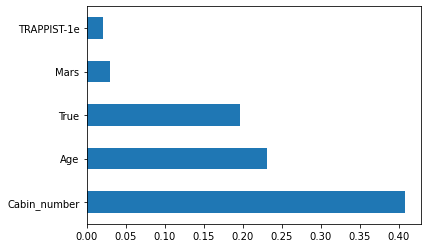

In [44]:
tree_reg = ExtraTreeClassifier()
tree_reg.fit(X_train_scaled,y_train)
print(tree_reg.feature_importances_)

#Top 5 important feature
features_importance = pd.Series(tree_reg.feature_importances_,index=X.columns)
features_importance.nlargest(5).plot(kind='barh')
plt.show()

These are the top 5 features which are important

In [45]:
from sklearn.svm import SVC
model = SVC()

model.fit(X_train_scaled,y_train)
y_pred = model.predict(X_valid_scaled)

In [46]:
accuracy_score(y_valid,y_pred)

0.7446808510638298

In [47]:
# X_test
sub = model.predict(X_test)
sub

array([0., 0., 0., ..., 0., 0., 0.])

In [50]:
# import pickle
# pickle.dump(model,open('spaceship.pkl','wb'))

In [51]:
X

,Age,Total_Expense,Cabin_number,Europa,Mars,True,PSO J318.5-22,TRAPPIST-1e,True,adult,children,senior,C,E,F,G,O,S,X
PassengerId,,,,,,,,,,,,,,,,,,,
0001_01,39.0,29.3,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
0002_01,24.0,29.3,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
0003_01,58.0,29.3,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0
0003_02,33.0,29.3,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0
0004_01,16.0,13.7,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,41.0,29.3,98,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0
9278_01,18.0,29.3,1499,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0
9279_01,26.0,29.3,1500,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0


In [52]:
y

PassengerId
0001_01    0.0
0002_01    1.0
0003_01    0.0
0003_02    0.0
0004_01    1.0
          ... 
9276_01    0.0
9278_01    0.0
9279_01    1.0
9280_01    0.0
9280_02    1.0
Name: Transported, Length: 8693, dtype: float64